In [52]:
print("hello world")

hello world


In [53]:
!pip install yfinance pandas numpy matplotlib ta


In [54]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
%matplotlib inline


confirguration 

In [55]:
CASH_START = 10000
INTERVAL = "1h"
PERIOD = "6mo"
EMA_FAST = 5
EMA_SLOW = 10
RSI_PERIOD = 14
RSI_BUY = 45
RSI_SELL = 55
TRADE_SIZE = 0.2

functions

In [56]:
def clean_yf_dataframe(df):
    """Flatten multi-index columns and ensure 1-D numeric series."""
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df = df.copy()
    for col in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
        if col in df.columns and isinstance(df[col], pd.DataFrame):
            df[col] = df[col].iloc[:, 0]
    df.dropna(inplace=True)
    return df

def compute_indicators(df):
    close = df["Close"].astype(float).squeeze()  # make sure it's 1-D
    df["ema_fast"] = close.ewm(span=EMA_FAST).mean()
    df["ema_slow"] = close.ewm(span=EMA_SLOW).mean()
    df["rsi"] = ta.momentum.RSIIndicator(close, window=RSI_PERIOD).rsi()
    return df

def backtest(df):
    cash, pos = CASH_START, 0
    portfolio = []
    for i in range(EMA_SLOW, len(df)):
        fast, slow, rsi = df["ema_fast"].iloc[i], df["ema_slow"].iloc[i], df["rsi"].iloc[i]
        price = df["Close"].iloc[i]
        if fast > slow and rsi < RSI_BUY and pos == 0:
            invest = cash * TRADE_SIZE
            pos = invest / price
            cash -= invest
        elif fast < slow and rsi > RSI_SELL and pos > 0:
            cash += pos * price
            pos = 0
        portfolio.append(cash + pos * price)
    return portfolio, cash, pos


functions

Enter stock symbol (e.g. AAPL, TSLA, NVDA):  tsla


Fetching 6mo of 1h data for TSLA...

--- Backtest Results for TSLA ---
Final Equity: $10,308.65
Return: 3.09%


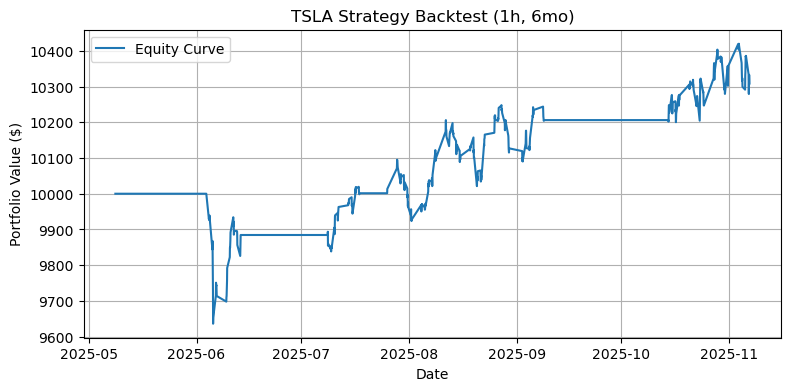

In [57]:
symbol = input("Enter stock symbol (e.g. AAPL, TSLA, NVDA): ").strip().upper()
print(f"Fetching {PERIOD} of {INTERVAL} data for {symbol}...")

df = yf.download(symbol, period=PERIOD, interval=INTERVAL, progress=False, auto_adjust=False)
df = clean_yf_dataframe(df)

if df.empty:
    print("No data returned — try another symbol or period.")
else:
    df = compute_indicators(df)
    portfolio, cash, pos = backtest(df)
    final_value = cash + pos * df["Close"].iloc[-1]
    ret = (final_value - CASH_START) / CASH_START * 100

    print(f"\n--- Backtest Results for {symbol} ---")
    print(f"Final Equity: ${final_value:,.2f}")
    print(f"Return: {ret:.2f}%")

    plt.figure(figsize=(9,4))
    plt.plot(df.index[EMA_SLOW:], portfolio, label="Equity Curve")
    plt.title(f"{symbol} Strategy Backtest ({INTERVAL}, {PERIOD})")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid(True)
    plt.show()


Performance metrics


In [58]:
import numpy as np

# --- PERFORMANCE METRICS ---
def compute_performance_metrics(df, portfolio):
    portfolio = np.array(portfolio)
    returns = np.diff(portfolio) / portfolio[:-1]  # daily/hourly returns

    # Total return
    total_return = (portfolio[-1] - portfolio[0]) / portfolio[0]

    # CAGR (approx)
    n_years = len(portfolio) / 252  # assumes daily data
    CAGR = (1 + total_return) ** (1 / max(n_years, 1e-9)) - 1

    # Max Drawdown
    rolling_max = np.maximum.accumulate(portfolio)
    drawdown = (portfolio - rolling_max) / rolling_max
    max_dd = drawdown.min()

    # Sharpe Ratio
    mean_ret = np.mean(returns)
    std_ret = np.std(returns)
    sharpe = (mean_ret / std_ret) * np.sqrt(252) if std_ret != 0 else 0

    print("\n--- Quantitative Performance ---")
    print(f"Total Return: {total_return*100:.2f}%")
    print(f"CAGR: {CAGR*100:.2f}%")
    print(f"Max Drawdown: {max_dd*100:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")

# call it
compute_performance_metrics(df, portfolio)



--- Quantitative Performance ---
Total Return: 3.09%
CAGR: 0.87%
Max Drawdown: -3.64%
Sharpe Ratio: 0.38


multi class analysis

Running backtest on: AMZN, HDFCBANK.NS, LT.NS, ITC.NS, AAPL


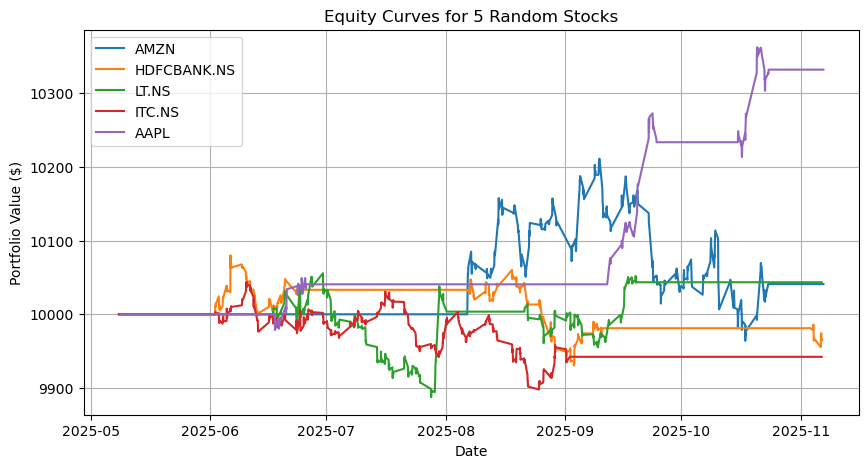

,Symbol,Final Value,Return %,Max Drawdown %
4,AAPL,10332.21,3.32,-0.58
2,LT.NS,10043.49,0.43,-1.67
0,AMZN,10040.99,0.41,-2.42
1,HDFCBANK.NS,9965.32,-0.35,-1.48
3,ITC.NS,9942.23,-0.58,-1.46


In [59]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import random
import matplotlib.pyplot as plt
%matplotlib inline

CASH_START = 10000
INTERVAL = "1h"
PERIOD = "6mo"
EMA_FAST = 5
EMA_SLOW = 10
RSI_PERIOD = 14
RSI_BUY = 45
RSI_SELL = 55
TRADE_SIZE = 0.2

# You can mix NSE and U.S. tickers
ALL_TICKERS = [
    "AAPL", "MSFT", "TSLA", "GOOG", "AMZN",
    "RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS",
    "ITC.NS", "SBIN.NS", "BAJFINANCE.NS", "LT.NS", "HINDUNILVR.NS"
]

# ---------------- HELPERS ----------------
def clean_yf_dataframe(df):
    """Flatten multi-index columns and ensure 1-D numeric series."""
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    for col in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
        if col in df.columns and isinstance(df[col], pd.DataFrame):
            df[col] = df[col].iloc[:, 0]
    df.dropna(inplace=True)
    return df

def compute_indicators(df):
    close = df["Close"].astype(float).squeeze()
    df["ema_fast"] = close.ewm(span=EMA_FAST).mean()
    df["ema_slow"] = close.ewm(span=EMA_SLOW).mean()
    df["rsi"] = ta.momentum.RSIIndicator(close, window=RSI_PERIOD).rsi()
    return df

def backtest(df):
    cash, pos = CASH_START, 0
    portfolio = []
    for i in range(EMA_SLOW, len(df)):
        fast, slow, rsi = df["ema_fast"].iloc[i], df["ema_slow"].iloc[i], df["rsi"].iloc[i]
        price = df["Close"].iloc[i]
        if fast > slow and rsi < RSI_BUY and pos == 0:
            invest = cash * TRADE_SIZE
            pos = invest / price
            cash -= invest
        elif fast < slow and rsi > RSI_SELL and pos > 0:
            cash += pos * price
            pos = 0
        portfolio.append(cash + pos * price)
    return portfolio, cash, pos

def compute_metrics(portfolio):
    portfolio = np.array(portfolio)
    total_return = (portfolio[-1] - portfolio[0]) / portfolio[0] * 100
    drawdown = (portfolio - np.maximum.accumulate(portfolio)) / np.maximum.accumulate(portfolio)
    max_dd = drawdown.min() * 100
    return total_return, max_dd

# ---------------- MAIN ----------------
random_tickers = random.sample(ALL_TICKERS, 5)
print("Running backtest on:", ", ".join(random_tickers))

results = []

plt.figure(figsize=(10,5))
for symbol in random_tickers:
    try:
        df = yf.download(symbol, period=PERIOD, interval=INTERVAL, progress=False, auto_adjust=False)
        df = clean_yf_dataframe(df)
        if df.empty: 
            print(f"{symbol}: No data")
            continue
        df = compute_indicators(df)
        portfolio, cash, pos = backtest(df)
        if not portfolio:
            continue
        final_value = cash + pos * df["Close"].iloc[-1]
        total_return, max_dd = compute_metrics(portfolio)
        results.append({"Symbol": symbol, "Final Value": final_value, "Return %": total_return, "Max Drawdown %": max_dd})
        plt.plot(df.index[EMA_SLOW:], portfolio, label=symbol)
    except Exception as e:
        print(f"Error with {symbol}: {e}")

plt.title("Equity Curves for 5 Random Stocks")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

if results:
    df_results = pd.DataFrame(results).round(2)
    display(df_results.sort_values(by="Return %", ascending=False))
else:
    print("No results generated.")
